<a href="https://colab.research.google.com/github/Mandersss/AML-AVGAN-22/blob/main/Revelez_Part1_A_V_Seperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> <font color = Maroon > Name: </font>Armando Revelez
## <b> <font color = Maroon> Course: </font> AML ECE5995
## <font color = Maroon> Project: </font> Artery & Vein Separation (A/V Segmentation) from CT/CTA Scans </b>


In [1]:
# ---- PRELIMINARY IMPORTS ---- #

# torch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

valid_ratio = 0.3

# torch vision
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

# Supporting Libraries
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Data imports
!pip install SimpleITK

import SimpleITK as sitk
from google.colab import files

## <b> <font color = orange>  UNet Architecture </font> </b>
Intention: 
- Reduce image down and rebuild with segmentation knowledge
- Utilize bridge information between early stages and latter stages (grey arrows) to provide additional reference as image is segmented
- This bridge connects what is called a <font color = red> <b> Semantic Gap </b> </font>
- Semantic Definition - <font color = lightblue> "Relating to meaning in language or logic" </font>
- Meaning consecutive convolutions leading to segmented images can reference earlier stages of the image to supplement the outcome.


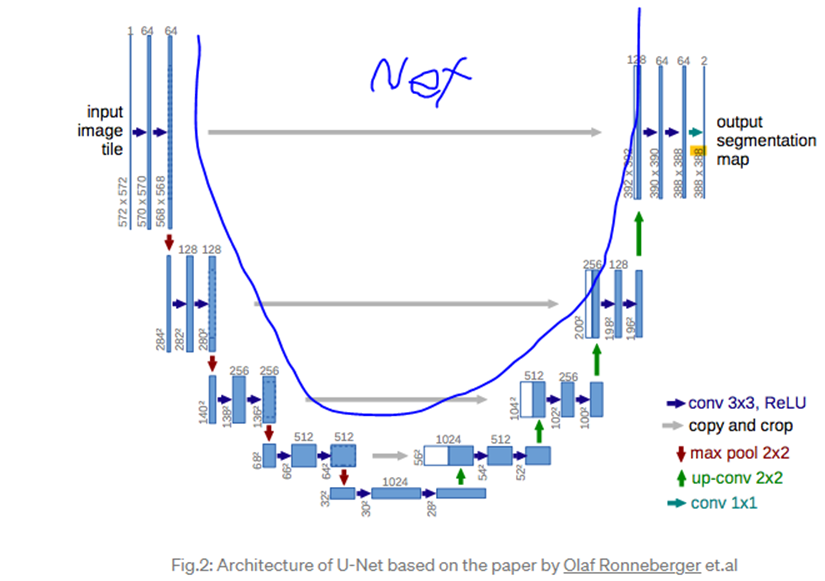

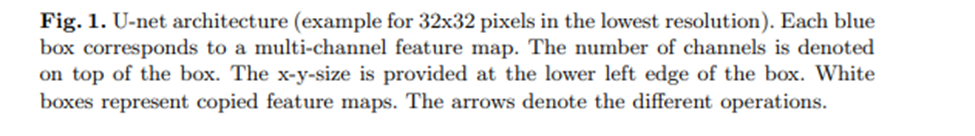

## <b> <font color = orange>  UNet++ <font color = red> : NOT USING</font> </font> </b>
Why is it differnt: 
- UNet++ modifies the bridges of the semantic gap to interconnect more information into the segmented image output using convolutions (As shown in next cell)
- In the image below the LHS dotted rectangle is the "backbone" / encoder / left side of the "U" from the above image. 
- The RHS is the decoder / right side of the "U" 
- The area in between is filled with convolutional layers that essentially compile information from all stages of the NN to provide more detailed information to the decoder stage. This adds more detail to the bridges that connected semantic gaps in UNet. 

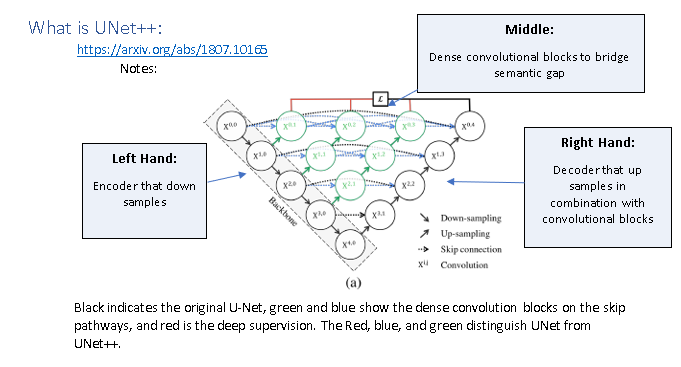

#<b> <font color = Maroon> Step 1 </font> : Create UNet CNN Pytorch definition<font color=red> </b>
* Derived from Unet implementation (https://github.com/zhixuhao/unet/blob/master/model.py) implemented with Keras, and the above visual of UNet from it's original research paper

* UNet++ will be a secondary goal to improve the segmentation, since it involves complex convolutional connections
## <b> <font color = green>Aim to produce segmented images from the network </font> </b>
* Data Configuration: 
  * Lung CT scans for a 3D volume of slices:
  * (<font color = orange> 512x512 </font>) Image Area * (<font color = orange> 400 </font> ) Slices Tall  
  * Voxel value 0 - 255
* Network Training:
  * Provided the correclty labeled data compare the network output to determine loss and accuracy 




In [19]:
"""
 # ---- V1 IMPLMENTATION ---- #
 #:v1
 # Description: 
 # ... This version implments UNet as seen in the photograph where the dimensions are reduced 
"""
class UNet_V1(nn.Module):
  def __init__(self):
    super(UNet_V1, self).__init__()

    ###-------------------------- ENCODER STAGE ------------------------ ###
    ######## ENCODER BLOCK 1 : - Sequential definition:
    self.ENCODER_BL1 = unet_block(1,64,1)
    # MaxPool1: Output dims = .5 Input dims
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 2 : - Sequential definition:
    self.ENCODER_BL2 = unet_block(64,128,1)
    # MaxPool2: Output dims = .5 Input dims
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 3 :
    # Enocder block 3 - Sequential definition:
    self.ENCODER_BL3 = unet_block(128,256,1)
    # MaxPool3: Output dims = .5 Input dims
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 4 : - Sequential definition:
    self.ENCODER_BL4 = unet_block(256,512,1)
    # MaxPool4: Output dims = .5 Input dims
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    ######## ENCODER BLOCK 5 : Sequential definition:
    self.ENCODER_BL5 = unet_block(512,1024,1)

    # Encoder to Decoder transition...
    ###------------------------- SEMANTIC GAP ---------------------------###

    # For UNet++ this would include a bunch of convolutions

    #--------------------------- DECODER STAGE --------------------------- #
    # Decoder Stage ... 

    # UpConv1: 3x3 inchannels 1024, outchannels 512, input Pxl X Pxl
    self.UPCONV_1 = upconv(1024,512)

    # Semantic Gap Info Passoff 4 ....
    # Concatinate = ENCODER_BL4 output + ENCODER_BL5 output 

    ######## DECODER BLOCK 1 : - Sequential definition:
    self.DECODER_BL1 = unet_block(1024,512,1)

    # UpConv2: 3x3 inchannels 512, outchannels 256, input Pxl X Pxl
    self.UPCONV_2 = upconv(512,256)

    # Semantic Gap Info Recieve 3 ....

    ######## DECODER BLOCK 2 : - Sequential definition:
    self.DECODER_BL2 = unet_block(512,256,1)
    
    # UpConv3: 3x3 inchannels 256, outchannels 128, input Pxl X Pxl
    self.UPCONV_3 = upconv(256,128)

    # Semantic Gap Info Recieve 2 ....

    ######## DECODER BLOCK 3 : - Sequential definition:
    self.DECODER_BL3 = unet_block(256, 128,1)

    # UpConv4: 3x3 inchannels 128, outchannels 64, input Pxl X Pxl
    self.UPCONV_4 = upconv(128,64)

    # Semantic Gap Info Recieve 1 ....

    ####### DECODER BLOCK 4 - Sequential definition:
    self.DECODER_BL4 = unet_block(128,64,1)

    # Conv9c: 1x1 inchannels 64, outchannels 2, input Pxl X Pxl
    self.conv_END = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=1,  dilation = 1, stride=1, padding=0)
    ) 
          
  def forward(self, x):
    # ----  IMPLEMENTATION ---- #
    ######## ENCODER BACKBONE  
    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1)
    # print("After Maxpool 1: ", m1.shape)

    # Passoff x1

    # print("Before Encoder 2: ", m1.shape)
    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 1: ", m2.shape)

    # Passoff x2

    # print("Before Encoder 3: ", m2.shape)
    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 1: ", m3.shape)

    # Passoff x3

    # print("Before Encoder 4: ", m3.shape)
    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 1: ", m4.shape)

    # Passoff x4

    # print("Before Encoder 5: ", m4.shape)
    x5 = self.ENCODER_BL5(m4)
    # print("After Encoder 5: ", x5.shape)

    ######## SEMANTIC GAP 


    ######## DECODER SECTION 

    # print("Before UpConv: ", x5.shape)
    u1 = self.UPCONV_1(x5)
    # print("After UpConv: ", u1.shape)

    x41 = copy_crop(x4,u1)

    # print("Before Decoder 1: ", x41.shape)
    x7 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x7.shape)

    # print("Before UpConv2: ", x7.shape)
    u2 = self.UPCONV_2(x7)
    # print("After UpConv2: ", u2.shape)

    x32 = copy_crop(x3,u2)

    # print("Before Decoder 2: ", x32.shape)
    x8 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x8.shape)

    # print("Before UpConv3: ", x8.shape)
    u3 = self.UPCONV_3(x8)
    # print("After UpConv3: ", u3.shape)

    x23 = copy_crop(x2,u3)

    # print("Before Decoder 3: ", x23.shape)
    x9 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x9.shape)

    # print("Before UpConv4: ", x9.shape)
    u4 = self.UPCONV_4(x9)
    # print("After UpConv3: ", u4.shape)

    x14 = copy_crop(x1,u4)
    
    # print("Before Decoder 4: ", x14.shape)
    x10 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x10.shape)

    x_out = self.conv_END(x10)
    # print("After final convolution: ", x_out.shape)

    return x_out

"""
 # ---- V2 IMPLMENTATION ---- #
 #:v2
 # Description: 
 # ... This version alters the convolutional blocks to rebuild an image of the same size as the original.
 # ... This caters to an attempt at image segmenatation based on the UNet Architecture
"""
class UNet_V2(nn.Module):
  def __init__(self):
    super(UNet_V2, self).__init__()

    ###-------------------------- ENCODER STAGE ------------------------ ###
    ######## ENCODER BLOCK 1 : - Sequential definition:
    self.ENCODER_BL1 = unet_block(1,64,2)
    # MaxPool1: Output dims = .5 Input dims
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 2 : - Sequential definition:
    self.ENCODER_BL2 = unet_block(64,128,2)
    # MaxPool2: Output dims = .5 Input dims
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 3 :
    # Enocder block 3 - Sequential definition:
    self.ENCODER_BL3 = unet_block(128,256,2)
    # MaxPool3: Output dims = .5 Input dims
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 4 : - Sequential definition:
    self.ENCODER_BL4 = unet_block(256,512,2)
    # MaxPool4: Output dims = .5 Input dims
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    ######## ENCODER BLOCK 5 : Sequential definition:
    self.ENCODER_BL5 = unet_block(512,1024,2)

    # Encoder to Decoder transition...
    ###------------------------- SEMANTIC GAP ---------------------------###

    # For UNet++ this would include a bunch of convolutions

    #--------------------------- DECODER STAGE --------------------------- #
    # Decoder Stage ... 

    # UpConv1: 3x3 inchannels 1024, outchannels 512, input Pxl X Pxl
    self.UPCONV_1 = upconv(1024,512)

    # Semantic Gap Info Passoff 4 ....
    # Concatinate = ENCODER_BL4 output + ENCODER_BL5 output 

    ######## DECODER BLOCK 1 : - Sequential definition:
    self.DECODER_BL1 = unet_block(1024,512,2)

    # UpConv2: 3x3 inchannels 512, outchannels 256, input Pxl X Pxl
    self.UPCONV_2 = upconv(512,256)

    # Semantic Gap Info Recieve 3 ....

    ######## DECODER BLOCK 2 : - Sequential definition:
    self.DECODER_BL2 = unet_block(512,256,2)
    
    # UpConv3: 3x3 inchannels 256, outchannels 128, input Pxl X Pxl
    self.UPCONV_3 = upconv(256,128)

    # Semantic Gap Info Recieve 2 ....

    ######## DECODER BLOCK 3 : - Sequential definition:
    self.DECODER_BL3 = unet_block(256, 128,2)

    # UpConv4: 3x3 inchannels 128, outchannels 64, input Pxl X Pxl
    self.UPCONV_4 = upconv(128,64)

    # Semantic Gap Info Recieve 1 ....

    ####### DECODER BLOCK 4 - Sequential definition:
    self.DECODER_BL4 = unet_block(128,64,2)

    # Conv9c: 1x1 inchannels 64, outchannels 2, input Pxl X Pxl
    self.conv_END = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=1,  dilation = 1, stride=1, padding=0)
    ) 
          
  def forward(self, x):
    # ----  IMPLEMENTATION ---- #
    ######## ENCODER BACKBONE  
    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1)
    # print("After Maxpool 1: ", m1.shape)

    # Passoff x1
    # print("Before Encoder 2: ", m1.shape)
    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 2: ", m2.shape)

    # Passoff x2

    # print("Before Encoder 3: ", m2.shape)
    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 3: ", m3.shape)

    # Passoff x3
    # print("Before Encoder 4: ", m3.shape)
    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 4: ", m4.shape)

    # Passoff x4
    # print("Before Encoder 5: ", m4.shape)
    x5 = self.ENCODER_BL5(m4)
    # print("After Encoder 5: ", x5.shape)

    ######## SEMANTIC GAP 


    ######## DECODER SECTION 
    # print("Before UpConv: ", x5.shape)
    u1 = self.UPCONV_1(x5) 
    # print("After UpConv: ", u1.shape)

    x41 = copy_crop(x4,u1)

    # print("Before Decoder 1: ", x41.shape)
    x7 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x7.shape)

    # print("Before UpConv2: ", x7.shape)
    u2 = self.UPCONV_2(x7)
    # print("After UpConv2: ", u2.shape)

    x32 = copy_crop(x3,u2)

    # print("Before Decoder 2: ", x32.shape)
    x8 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x8.shape)

    # print("Before UpConv3: ", x8.shape)
    u3 = self.UPCONV_3(x8)
    # print("After UpConv3: ", u3.shape)

    x23 = copy_crop(x2,u3)

    # print("Before Decoder 3: ", x23.shape)
    x9 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x9.shape)

    # print("Before UpConv4: ", x9.shape)
    u4 = self.UPCONV_4(x9)
    # print("After UpConv3: ", u4.shape)

    x14 = copy_crop(x1,u4)
    
    # print("Before Decoder 4: ", x14.shape)
    x10 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x10.shape)

    x_out = self.conv_END(x10)
    # print("After final convolution: ", x_out.shape)

    return x_out

"""
# Name: copy_crop
# Paramaters: Encoder output tensor, up convolution tensor
# Details:
# ... When each semantic gap is bridged, it is described as a "Copy and crop".
# ... It copies the output of the encoder block, to be received and included in the decoding stage.
# ... The tensor from the encoder stage must have it's image dimension cropped to fit the up convolution, ....
# ... THE CHANNELS from the up convolution and encoder stage output ARE CONCATINATED. ...
# ... Each decoder stage eventually produces the segemnted output.
"""
def copy_crop(enc_out, up_conv):    
    # Trim the image dimensions to fit
    enc_out_crop = T.functional.crop(enc_out,
                                      0,0, # Crop from origin
                                      up_conv.shape[2], # Trim photo to dimensions of x6
                                      up_conv.shape[2])
    
    # Concat - enc_out + up_conv, enc_out > up_conv -> trim encoder output to match up_conv
    dec_in = torch.cat((up_conv,enc_out_crop),1)
   
    return dec_in

"""
# Name: unet_block
# Parameters,1: in/out channels
# Description: 
# ... UNet Encoder/Decoder block re-usable definition. 
# ... Each block reduces the image dimensions by 4, and halves the input channels.
"""
def unet_block(inchannels,outchannels,version):
  # Reduce down image dimensions as in the original paper
  if version == 1:
    return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=1, padding=0, dilation =1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=0, dilation =1),
        nn.ReLU(True)
      ) 
  # Modify the convolutions to retain and rebuild the original dimensions
  elif version == 2:
    return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, stride=1, padding=1, dilation =1),
        nn.ReLU(True)
      ) 
    

"""
# Name: upconv
# Parameters: in/out channels
# Description: 
# ... Up-convolution consisting of a convolution and an upsample.
"""
def upconv(inchannels,outchannels):
  return nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size=2, stride=1, padding=1, dilation =2),
        nn.Upsample(scale_factor=2,mode ='bilinear',align_corners=False)
    )


### **Pytorch function testing & Network pass through verificaiton** 

In [17]:
"""
# ------------------------------------------------- #
# ------------  PYTORCH TESTING BLOCK  ------------ #
"""
import torch.nn as nn
import torch.nn.functional as F

m1 = nn.Conv2d(in_channels =6, out_channels = 32,kernel_size = 4, stride=1,padding = 1)
m2 = nn.Conv2d(in_channels =6, out_channels = 12,kernel_size = 9, stride=1,padding = 3)
P = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

input = torch.randn(20, 6, 32,32) # Assume this is 4D?


output = m1(input)
output2 = P(input)
output3 = m2(input)

print(type(input))
print("\n Input tensor: \t\t\t",input.shape,
      "\n Conv2d kernal 3: \t\t",output.shape,
      "\n Conv2d kernal 6: \t\t",output3.shape,
      '\n MaxPool2D: \t\t\t',output2.shape)

<class 'torch.Tensor'>

 Input tensor: 			 torch.Size([20, 6, 32, 32]) 
 Conv2d kernal 3: 		 torch.Size([20, 32, 31, 31]) 
 Conv2d kernal 6: 		 torch.Size([20, 12, 30, 30]) 
 MaxPool2D: 			 torch.Size([20, 6, 16, 16])


In [20]:
# Random testing

# Did this to re-update net everytime I tweaked optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

testInput = torch.rand(1,1,512,512).to(device)
net = UNet_V1().to(device)
net2 = UNet_V2().to(device)

outputs = net2(testInput)

# print("\n Input size: ", testInput.shape)
# print("\n Cropping test:", T.functional.crop(testInput, 0,0,testInput.shape[2] -1 - 10,testInput.shape[3] - 1- 10).shape)
# print("\n Padding test: ", F.pad(testInput,(0,0,
#                                             0,0,
#                                             4,5,
#                                             0,0,)).shape )


# <font color = Maroon> Step 2 </font> : Load the CT/CTA image training and validation sets, and possible transforms to be applied.

In [21]:
"""
  # Class name: CT_Slices_Dataset
  # Parameters:
  #     - CT_Scan (ndarray): 3D volume with a number of image slices  
  #     - image_size (int): dimensions of each slice
  # Description:
  #     Create a custom data loader to manage out CT scan slices to feed into network
  """  

from matplotlib import image

class CT_Slices_Dataset(Dataset):

  def __init__(self, Masks, CT_Scan, image_size, transforms=None, target_transforms = None):
    super(CT_Slices_Dataset, self).__init__()

    # Pre specified transforms to improve network reading
    self.transforms = transforms
    self.target_transforms = target_transforms
    self.image_size = image_size

    # CT scans    
    self.images = []
    # CT Scan Masks
    self.img_labels = []
    
    # Iterate through each slice and append it to the list of images 
    for i in range(CT_Scan.shape[0]):
      self.images.append(CT_Scan[i]) # Add image
      self.img_labels.append(Masks[i]) # Add corresponding mask


  def __len__(self):
        return len(self.images)

  def __getitem__(self, batch_index: int):
    # For now this will only have one batch

    # Make sure we don't exceed the set of images
    if batch_index < self.__len__():

      # Apply transforms if we made them
      if self.transforms == None:
        CT_Slice = self.images[batch_index]
      else: 
        CT_Slice = self.transforms(self.images[batch_index])

      # Apply transforms if we made them
      if self.target_transforms == None:
        Mask = self.img_labels[batch_index]
      else: 
        Mask = self.target_transforms(self.img_labels[batch_index])

    # If we do return an empty image
    else: 
      return np.zeros_like(self.image_size,self.image_size), np.zeros_like(self.image_size,self.image_size)

    # Return the CT_Slice and Maks on the index of image in this batch?
    return CT_Slice , Mask

In [22]:

""" 
Step 2: Create / Load in Data
"""

# ---- Quick helper function ---- #
def typeAndShape(input):
  print(type(input),input.shape)

# ---- DATA IMPORTS ---- #
from google.colab import files
#### Soheils provided boiler plate import ####
uploaded = files.upload()

"""
The only way I could access the files from colab was by accessing the local onedrive share file and adding images to the session
"""
for fn in uploaded.keys():
  # This will prompt for document upload on local machine
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# ---- DATA TRANSFORMATION ---- #

# CT_Scan trnsformations
CT_Scan_transforms =transforms.Compose(
    [
     # define your data augmentation HERE. You can start by uncomment the following line
     
      transforms.ToTensor(),
      # transforms.Grayscale(),
      # transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR),
      # transforms.RandomRotation(degrees = 30)
     ])

# Mask transformations
Mask_transforms = transforms.Compose(
    [
     # define your data augmentation HERE. You can start by uncomment the following line
     
     transforms.ToTensor(),
    #  transforms.Grayscale(),
    #  transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR), # This is the primary alteration to allow for image output comparison
    # transforms.RandomRotation(degrees = 30)
     ])

# ------ IMAGE ASSIGNMENT ------ #
imfn = "image1.nii.gz" # image filename
im = sitk.ReadImage(imfn)

vssmskfn = "image1-vessels.nii.gz" # vessel mask filename
vssmsk = sitk.ReadImage(vssmskfn)
  
# ---- DATA IMPORTS -> DATALOADER ---- #
im_ndarr = sitk.GetArrayFromImage(im)
vs_ndarr = sitk.GetArrayFromImage(vssmsk)

typeAndShape(im_ndarr)

# Try using this damn dataloader thing
dataset = CT_Slices_Dataset(Masks = vs_ndarr, CT_Scan = im_ndarr, image_size = im_ndarr.shape[1], transforms=CT_Scan_transforms, target_transforms=Mask_transforms)
print(len(dataset))
# print(dataset[300])

# We have a training set :)
CT_IN_trainloader = DataLoader(dataset,shuffle=True)


<class 'numpy.ndarray'> (602, 512, 512)
602


# <font color = Maroon> Step 2.5 </font> : Visualize the CT/CTA scans dataset.

<class 'torch.Tensor'> torch.Size([1, 1, 512, 512])
<class 'torch.Tensor'> torch.Size([1, 1, 512, 512])
############ START NETWORK PASS THROUGH #############
############ END NETWORK PASS THROUGH #############
ISSUE: Current UNet structure removes segments of image


Text(0.5, 1.0, 'UNetV2: Out Image')

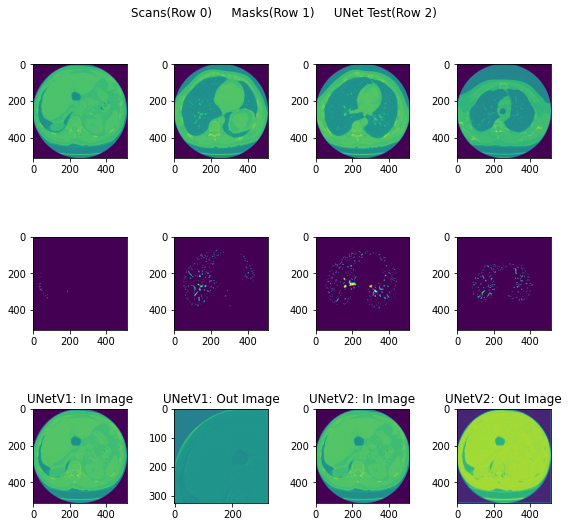

In [23]:
from torch._C import dtype
from SimpleITK.SimpleITK import Mask
""" 
Step 2.5: Visualize CT/CTA scans *If possible*
:input_data
"""

dataiter = iter(CT_IN_trainloader) 

fig ,ax = plt.subplots(3,4,figsize=(8,8))
fig.set_tight_layout(True)
# Quick visualization :)
for i in range(4):
  CT_Scans, Masks = dataiter.next()
  ax[0][i].imshow(np.squeeze(np.asarray(CT_Scans[0]))) 
  ax[1][i].imshow(np.squeeze(np.asarray(Masks))) 


# --------- NETWORK IN/OUT TESTING ------- #
for i, data in enumerate(CT_IN_trainloader, 0):
  inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

  # Graph one instance of the input and label
  if i == 1:
    break

# Look at the tensor dimensions
typeAndShape(inputs)
typeAndShape(labels)

# Network pass through
print("############ START NETWORK PASS THROUGH #############")
output_1 = net(inputs)
output_2 = net2(inputs)
print("############ END NETWORK PASS THROUGH #############")

# typeAndShape(output)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet Test(Row 2)")
ax[2][0].imshow(np.squeeze(np.asarray(inputs.cpu().detach().numpy()))) 
ax[2][0].set_title("UNetV1: In Image")
ax[2][1].imshow(np.squeeze(np.asarray(output_1.cpu().detach().numpy()))) 
ax[2][1].set_title("UNetV1: Out Image")

# print("ISSUE: Current UNet structure removes segments of image")

ax[2][2].imshow(np.squeeze(np.asarray(inputs.cpu().detach().numpy()))) 
ax[2][2].set_title("UNetV2: In Image")
ax[2][3].imshow(np.squeeze(np.asarray(output_2.cpu().detach().numpy()))) 
ax[2][3].set_title("UNetV2: Out Image")



# <font color = Maroon> Step 3 </font> : Define Network, Lossfunction & Optimizer for training loop


In [37]:
""" 
Step 3: Training setup
"""

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.cpu()
net2.cpu()

net_final = UNet_V2().to(device=device, dtype = torch.float)

print(net_final)
print("Total number of trainable CNN parameters=",sum([p.numel() for p in net.parameters()]))


################################################################################
# -------- TODO: Decide on optimal loss function and optimzers

lossfn = nn.CrossEntropyLoss()
learning_rate = .00006

# Idealized optimizers from HW5
# op1 = optim.SGD(net.parameters(),lr = learning_rate, momentum=.9, dampening=.5, weight_decay = 0.0002)
op2 = optim.Adam(net_final.parameters(), lr = learning_rate, betas = (.002,.99), eps = .4, weight_decay = 0.0006)

# # Specify which optimzer here
optimizer = op2

UNet_V2(
  (ENCODER_BL1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (MAXPOOL_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ENCODER_BL2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (MAXPOOL_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ENCODER_BL3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (MAXPOOL_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

# <font color = Maroon> Step 4 </font> : Training & Validation
## <font color = Green Apple> NOTE 04/05/2022: UNet output was altered to match dimensions of provided "labels", and can now be TRAINED!!! :) </font>

In [38]:

"""
Step 4: Training and Validation
"""

## Mount your google drive to current virtual machine and define the path to store the trained CNN parameters (optional)
# from google.colab import drive
# drive.mount('/content/drive')
# PATH = 'drive/My Drive/AML/Unet.pth'

import time

# define an empty list called validation_loss that might be helpful later in the early stopping implementation
validation_loss = []

start_time = time.time()
best_loss = np.float('inf')
epoch_loss = 0
num_epochs = 1

# ---- POST TRAINING ANALYSIS DELCARATIONS ---- #
t_loss = []
# v_loss = []
t_loss_prev = 0
v_loss_prev = 0
t_delta = [0]
# v_delta = [0]

# Moniter the changes in t_loss and v_loss
# v_decreasing = True
# t_decreasing = True
t_inc_count = 0
v_inc_count = 0

# ---- EPOCH LOOP ----- #
# --------------------- #
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    
    # -- TRAINING  --- #
    #----------------- #
    for i, data in enumerate(CT_IN_trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + update parameters
        outputs = net_final(inputs)
        loss = lossfn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss / (i+1)
    
    # ---- LOSS SAMPLE ---- #
    # Moved print statement
    t_loss.append(round(epoch_loss,3))

    # # -- Validation -- #
    # #----------------- #
    # with torch.no_grad(): 
    #   running_loss = 0.0
    #   for i, data in enumerate(validloader, 0):
    #       # get the inputs; data is a list of [inputs, labels]
    #       inputs, labels = data[0].to(device), data[1].to(device)

    #       # forward 
    #       outputs = net(inputs)
    #       loss = criterion(outputs, labels)

    #       # print statistics
    #       running_loss += loss.item()

    #   epoch_loss = running_loss / (i+1)

      # add epoch_loss at each iteration to the validation_loss list which is ...
      # ... LATER USED in the early stopping implementation
      # validation_loss.append(epoch_loss)

      # ---- LOSS SAMPLE ---- #
      # Moved Print Statment
      # v_loss.append(round(epoch_loss,3))

    # ---- FOR POST ANALYSIS ---- #
    t_delta.append(round((t_loss[-1] - t_loss_prev),3))
    # v_delta.append(round((v_loss[-1] - v_loss_prev),3))
    t_loss_prev = t_loss[-1]
    # v_loss_prev = v_loss[-1]
    
    # save the best model based on validation loss
    if epoch_loss < best_loss:

      # torch.save(net.state_dict(), PATH)
      best_loss = epoch_loss

    # ---- EARLY STOPPING ---- #
    # Stopping Mechanism: Watch for an unwanted increase in the loss values
    # Intention: Justify the increase in epochs to improve the data
    # Drawback: If the model was "ideal" and converged to a very small number this method won't prevent it.  

    # If v_delta is + for 2 conscutive epochs, improvement less likely
    # if epoch > 1 and v_delta[len(v_delta)-1] > 0:
      # v_inc_count+=1
      # print("v_loss increase @ epoch", epoch)
      # print(v_delta[len(v_delta)-1],v_delta[len(v_delta)-2])
      
    if t_delta[len(t_delta)-1] > 0 and t_delta[len(t_delta)-2] > 0:
      t_inc_count+=1
      print("t_loss increase @ epoch ", epoch)
      print(t_delta[len(t_delta)-1],t_delta[len(t_delta)-2])

    

    # Also make sure that the losses don't decrease too much
    # TODO: if consecutive changes super small, stop.

    if v_inc_count >= 5 or t_inc_count >= 5:
      print("steadily increase halting training @ epoch ", epoch)
      break



time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Finished Training in 8 mins


###<font color =maroon >Documenting the Training </font>

|Num Epochs| Loss Function | Train_Loss| Comments | Changes to Improve |
|----| ---- | ---- | ---- | ---- |
|1|torch.nn.L1Loss()|<b> 1.014 (Not <font color= blue>NaN</font>!)</b>| Bad, CPU was referenced (Still good loss)| N/A |
|1|torch.nn.L1Loss()|<b> .64 |Again, good loss but **bad visual comparison**| Harsher loss function, network weight stuff |


In [39]:
"""
Step 4.5: Evaluate training progress
"""

# Printing the results:
# 't_loss','t_delta')
print("{:<10} {:<10}".format('Epoch',
                                                         't_loss',
                                                         't_delta'))

for i in range(num_epochs):
  # ---- OUTPUT ANALYSIS ---- #
      # print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)
      # print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)
      # print("Epoch: ", epoch, " Max(t_loss,v_loss): ", )
      print("{:<10} {:<10}".format(i,
                                                               t_loss[i],
                                                               t_delta[i]))

Epoch      t_loss    
0          0.63      


# <font color = Maroon> Step 4 </font> : Test dataset and accuracy



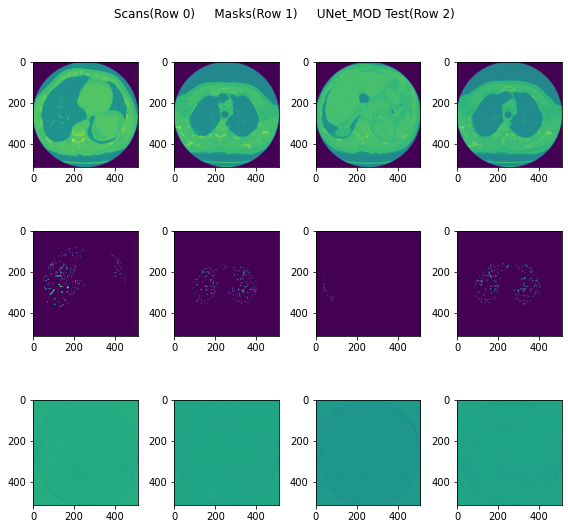

In [40]:
"""
Step 4: Visualizing output
"""

fig ,ax = plt.subplots(3,4,figsize=(8,8))
fig.set_tight_layout(True)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_MOD Test(Row 2)")

# --------- NETWORK IN/OUT TESTING ------- #
for i, data in enumerate(CT_IN_trainloader, 0):

  # Graph 4 instances of the input and label
  if i==4: break
  else:
    inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

    output_3 = net_final(inputs)

    ax[0][i].imshow(np.squeeze(np.squeeze(np.asarray(inputs.cpu().detach().numpy())))) 
    ax[1][i].imshow(np.squeeze(np.squeeze(np.asarray(labels.cpu().detach().numpy()))))
    ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(output_3.cpu().detach().numpy()))))


  


In [32]:
"""
Step 4.5: Testing accuracy?
"""

'\nStep 4.5: Testing accuracy?\n'